In [7]:
import os
import re
import argparse
from email import policy
from email.parser import BytesParser

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

import re
from nltk.stem import PorterStemmer

STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # strip URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)           # strip punctuation
    text = re.sub(r'\s+', ' ', text).strip()           # collapse whitespace

    tokens = [
        stemmer.stem(word)
        for word in text.split()
        if word not in STOPWORDS
    ]
    return ' '.join(tokens)
print("done")

done


In [8]:
def load_emails(maildir: str):
    texts, labels = [], []
    cnt=0
    for user in os.listdir(maildir):
        user_dir = os.path.join(maildir, user)
        if not os.path.isdir(user_dir):
            continue

        # only look at the “sent_items” folder
        folder_dir = os.path.join(user_dir, "sent_items")
        print(cnt)
        cnt+=1
        if not os.path.isdir(folder_dir):
            continue

        for fname in os.listdir(folder_dir):
            path = os.path.join(folder_dir, fname)
            try:
                with open(path, 'rb') as f:
                    msg = BytesParser(policy=policy.default).parse(f) #read binary
                body = msg.get_body(preferencelist=('plain',))
                if body is None:
                    continue
                raw = body.get_content()
                text = clean_text(raw)
                if not text:
                    continue
                tokens = [w for w in text.split() if w not in STOPWORDS]  #cleanning. Added lemmentatizn or stemming?
                texts.append(' '.join(tokens))
                labels.append(user)
            except Exception:
                continue

    return texts, labels
print("done")

done


In [9]:
import os
import sys
import statistics

def count_sent_messages(maildir):
    counts = []
    for user in os.listdir(maildir):
        sent_dir = os.path.join(maildir, user, "sent_items")
        if os.path.isdir(sent_dir):
            n = sum(
                1
                for fname in os.listdir(sent_dir)
                if os.path.isfile(os.path.join(sent_dir, fname))
            )
            counts.append(n)
    return counts

def getAve(maildir):
    counts = count_sent_messages(maildir)
    if not counts:
        print("No users or no sent_items folders found.")
        return

    avg    = statistics.mean(counts)
    med    = statistics.median(counts)
    stddev = statistics.stdev(counts)

    print(f"Average # of sent messages per user: {avg:.2f}")
    print(f"Median  # of sent messages per user: {med}")
    print(f"Std Dev # of sent messages per user: {stddev:.2f}")
getAve("/WAVE/projects/CSEN-140-Sp25/HHJ140Proj/Sent_Items_only")


Average # of sent messages per user: 278.82
Median  # of sent messages per user: 144.5
Std Dev # of sent messages per user: 318.26


In [10]:
DATA_DIR = "/WAVE/projects/CSEN-140-Sp25/HHJ140Proj/Sent_Items_only"     # path to Enron stuf
TEST_SIZE = 0.3 #preprocess work
RANDOM_STATE = 36

print("Loading and cleaning emails…")
texts, labels = load_emails(DATA_DIR)
print(f"→ {len(texts)} messages from {len(set(labels))} authors")
print(len(texts))

Loading and cleaning emails…
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
→ 37664 messages from 136 authors
37664


In [6]:
print(texts[:5])

[]


In [11]:
print("Vectorizing with TF–IDF…")
#changed parameters of vectorizer, improved accuracy 
vect = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2), 
    max_df=0.9,
    min_df=5,
    max_features=20000, 
)
#tried changing range, max_df, min_df 
#range: (1,1) has 80% accuracy while (2,2) has 77%
#max df: changing to 0.75 or 1 didn't affect accuracy
#min df: 1 has 82.33% and 5 had 82.41% (improvement)

#vect = TfidfVectorizer(max_features=20_000)
X = vect.fit_transform(texts)
y = labels

Vectorizing with TF–IDF…


In [12]:
from collections import Counter

counts = Counter(labels)

keep = {lbl for lbl, cnt in counts.items() if cnt >= 2}

texts_filt = [t for t, l in zip(texts, labels) if l in keep]
labels_filt = [l for l in labels if l in keep]

X = vect.transform(texts_filt)   
y = labels_filt

X_train, X_test, y_train, y_test = train_test_split( #split and train
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"→ Training on {X_train.shape[0]} docs; testing on {X_test.shape[0]}")

→ Training on 26364 docs; testing on 11299


In [13]:
from sklearn.svm import LinearSVC
import numpy as np

models = {
    #"Linear SVC": LinearSVC(C=1.0, max_iter=10000, dual=False)
    "Linear SVC":LinearSVC(C=0.5, max_iter=10000, dual=False) 
    #default squared hinge is best, iterations don't change accuracy
}

#ridge classifier second best
#best alpha is default alpha

#additional models 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial NB": MultinomialNB(),
    "Ridge Classifier": RidgeClassifier(alpha=1.5),
    "SGD Classifier": SGDClassifier(loss='log_loss'),  
    "Passive Aggressive": PassiveAggressiveClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "KNN (cosine)": KNeighborsClassifier(metric='cosine', n_neighbors=52),
    "Linear SVC": LinearSVC(C=0.4, max_iter=10000, dual=False)
}

results = {}
best_model = None
best_model_name = None
best_accuracy = 0
best_predictions = None

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    print("fitted")
    y_pred = model.predict(X_test)
    #print(classification_report(y_test, preds))
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name} with Accuracy: {acc:.4f}")
    results[name] = acc
    #print("Confusion matrix:")
    #print(confusion_matrix(y_test, preds))

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = name
        best_predictions = y_pred

print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")
print("\nClassification Report:")
#had to add the zero_division after changing vectors
print(classification_report(y_test, best_predictions, zero_division=0))



Logistic Regression
fitted

Model: Logistic Regression with Accuracy: 0.7651

Multinomial NB
fitted

Model: Multinomial NB with Accuracy: 0.4867

Ridge Classifier
fitted

Model: Ridge Classifier with Accuracy: 0.8203

SGD Classifier
fitted

Model: SGD Classifier with Accuracy: 0.7118

Passive Aggressive
fitted

Model: Passive Aggressive with Accuracy: 0.8064

Random Forest
fitted

Model: Random Forest with Accuracy: 0.8068

KNN (cosine)
fitted

Model: KNN (cosine) with Accuracy: 0.6268

Linear SVC
fitted

Model: Linear SVC with Accuracy: 0.8256

Best Model: Linear SVC with Accuracy: 0.8256

Classification Report:
                 precision    recall  f1-score   support

        allen-p       0.81      0.75      0.78       103
       arnold-j       0.78      0.74      0.76       216
        arora-h       0.93      0.65      0.76        20
       badeer-r       0.67      1.00      0.80         2
       bailey-s       1.00      1.00      1.00         4
         bass-e       0.75      0.7

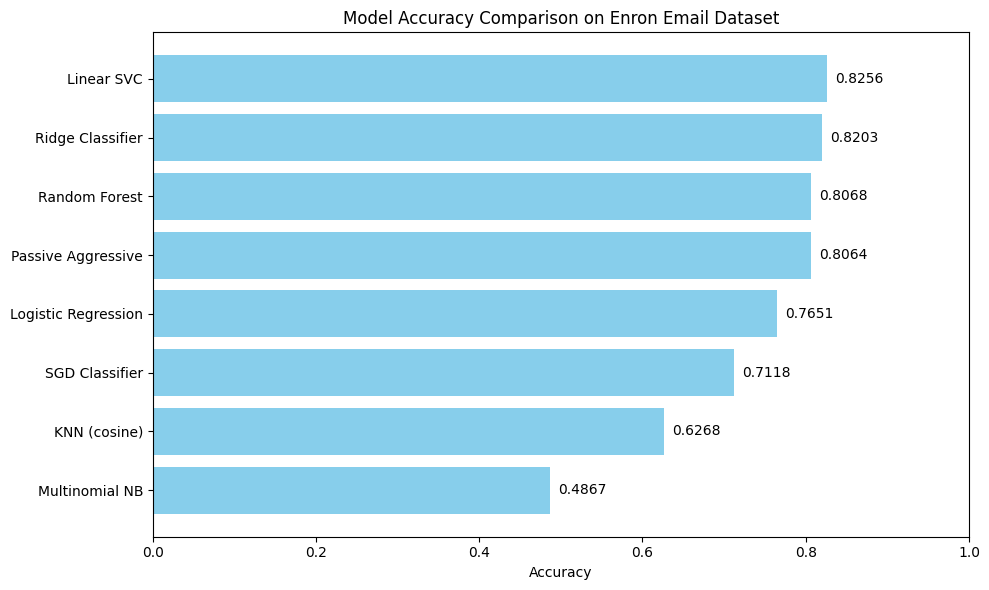

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#used to graph model vs accuracy
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(results_df["Model"], results_df["Accuracy"], color='skyblue')
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison on Enron Email Dataset")
plt.xlim(0, 1.0)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [15]:
#used to try to find better c for linear svc
#0.5 is best so far
accuracies = []
c_values = np.arange(0.1, 1.8, 0.1)
for c in c_values: 
    model = LinearSVC(C=c, max_iter=10000, dual=False)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"C={c:.1f} → Accuracy: {acc:.4f}")

C=0.1 → Accuracy: 0.8105
C=0.2 → Accuracy: 0.8217
C=0.3 → Accuracy: 0.8242
C=0.4 → Accuracy: 0.8256
C=0.5 → Accuracy: 0.8252
C=0.6 → Accuracy: 0.8246
C=0.7 → Accuracy: 0.8241
C=0.8 → Accuracy: 0.8224
C=0.9 → Accuracy: 0.8215
C=1.0 → Accuracy: 0.8217
C=1.1 → Accuracy: 0.8211
C=1.2 → Accuracy: 0.8207
C=1.3 → Accuracy: 0.8202
C=1.4 → Accuracy: 0.8196
C=1.5 → Accuracy: 0.8190
C=1.6 → Accuracy: 0.8186
C=1.7 → Accuracy: 0.8181


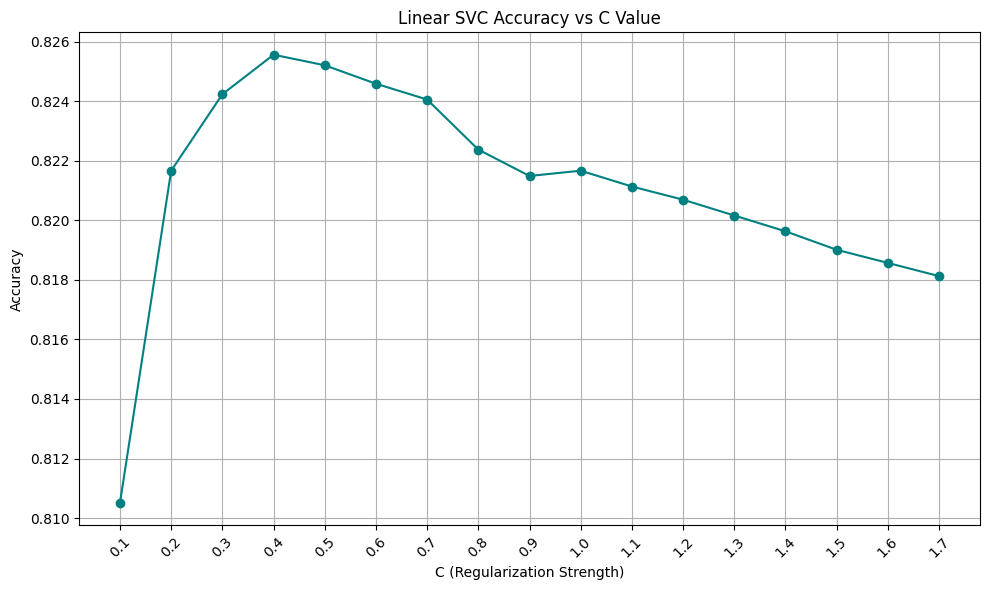

In [16]:
#used to plot for linear svc
plt.figure(figsize=(10, 6))
plt.plot(c_values, accuracies, marker='o', color='teal')
plt.title('Linear SVC Accuracy vs C Value')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(c_values, rotation=45)
plt.tight_layout()
plt.show()

In [17]:
#used to try finding better alpha for ridge
#1.5 is best so far
accuracies = []
alphas = np.arange(0.1, 1.8, 0.1)
for alpha in alphas:
    model = RidgeClassifier(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Alpha: {alpha:.2f} → Accuracy: {acc:.4f}")

Alpha: 0.10 → Accuracy: 0.8075
Alpha: 0.20 → Accuracy: 0.8133
Alpha: 0.30 → Accuracy: 0.8163
Alpha: 0.40 → Accuracy: 0.8183
Alpha: 0.50 → Accuracy: 0.8194
Alpha: 0.60 → Accuracy: 0.8200
Alpha: 0.70 → Accuracy: 0.8190
Alpha: 0.80 → Accuracy: 0.8200
Alpha: 0.90 → Accuracy: 0.8197
Alpha: 1.00 → Accuracy: 0.8199
Alpha: 1.10 → Accuracy: 0.8205
Alpha: 1.20 → Accuracy: 0.8207
Alpha: 1.30 → Accuracy: 0.8202
Alpha: 1.40 → Accuracy: 0.8202
Alpha: 1.50 → Accuracy: 0.8203
Alpha: 1.60 → Accuracy: 0.8194
Alpha: 1.70 → Accuracy: 0.8187


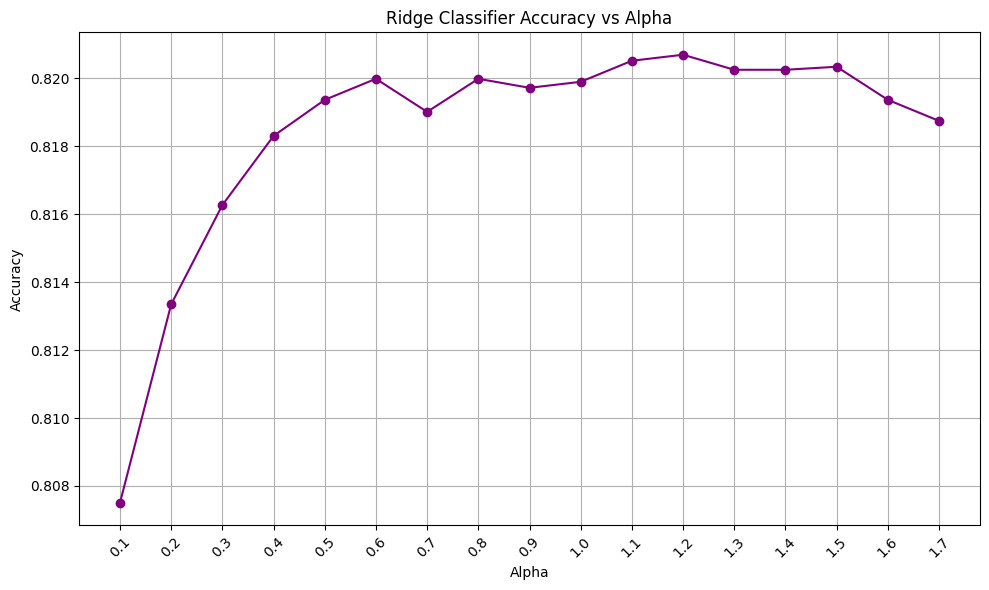

In [18]:
#used to plot for ridge classifier
plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracies, marker='o', linestyle='-', color='purple')
plt.title('Ridge Classifier Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(alphas, rotation=45)
plt.tight_layout()
plt.show()

In [31]:
#JoJo tested using a nn model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels_filt)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class DeeperNet(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(DeeperNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout = nn.Dropout(0.4)
        self.output = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        return self.output(x)

# Use correct input_dim
input_dim = X_train_tensor.shape[1]
model = DeeperNet(input_dim=input_dim, hidden_dim1=256, hidden_dim2=128, output_dim=len(le.classes_))

optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()
criterion= nn.MSELoss()
# Training loop
train_accuracies = []
test_accuracies = []
train_losses = []
num_epochs=100
for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Track training loss and accuracy
    train_losses.append(loss.item())
    _, predicted_train = torch.max(outputs, 1)
    correct_train = (predicted_train == y_train_tensor).sum().item()
    train_acc = correct_train / len(y_train_tensor)
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        _, predicted_test = torch.max(outputs_test, 1)
        correct_test = (predicted_test == y_test_tensor).sum().item()
        test_acc = correct_test / len(y_test_tensor)
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

/WAVE/users2/unix/jtorresmolina/.conda/envs/140wi25/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([26364])) that is different to the input size (torch.Size([26364, 135])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (135) must match the size of tensor b (26364) at non-singleton dimension 1

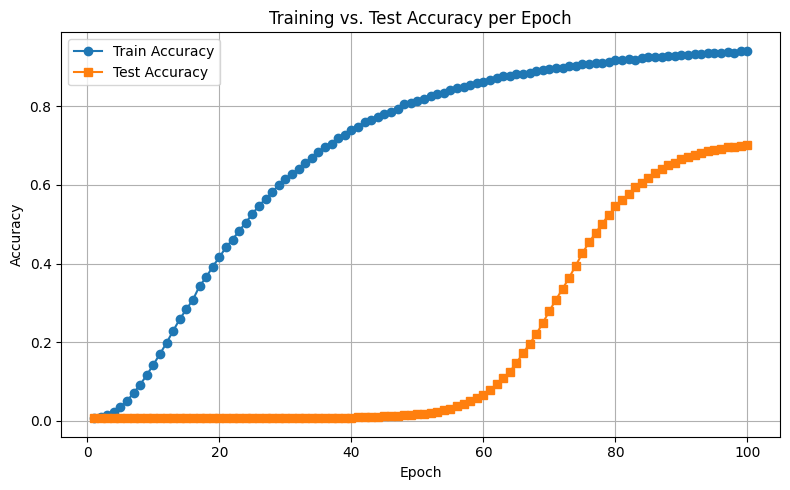

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', label="Test Accuracy")
plt.title("Training vs. Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
#These are the models JoJo is testing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
models = {
}

#modelsButPair =[()]
scores=[]

for i in range(1,100):
    kNumber= "k nearest neighbors k=" + str(i)
    models[kNumber]=KNeighborsClassifier(metric='cosine',n_neighbors=i)
    
    #modelsButPair[i-1]=zip(i,KNeighborsClassifier(n_neighbors=i))
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    print("fitted")
    preds = model.predict(X_test)
    score=accuracy_score(y_test, preds)
    scores.append(score)
    print(score)
    #print(classification_report(y_test, preds))


k nearest neighbors k=1
fitted
0.6235950084078237

k nearest neighbors k=2
fitted
0.582440923975573

k nearest neighbors k=3
fitted
0.5987255509337109

k nearest neighbors k=4
fitted
0.6037702451544384

k nearest neighbors k=5
fitted
0.6084609257456413

k nearest neighbors k=6
fitted
0.6139481370032747

k nearest neighbors k=7
fitted
0.6186388175944774

k nearest neighbors k=8
fitted
0.6197893618904328

k nearest neighbors k=9
fitted
0.6240375254447296

k nearest neighbors k=10
fitted
0.6289052128506948

k nearest neighbors k=11
fitted
0.6262501106292592

k nearest neighbors k=12
fitted
0.628993716258076

k nearest neighbors k=13
fitted
0.6298787503318878

k nearest neighbors k=14
fitted
0.6324453491459421

k nearest neighbors k=15
fitted
0.6325338525533233

k nearest neighbors k=16
fitted
0.6339499070714223

k nearest neighbors k=17
fitted
0.6359854854411895

k nearest neighbors k=18
fitted
0.6378440569961944

k nearest neighbors k=19
fitted
0.6381980706257191

k nearest neighbors k=

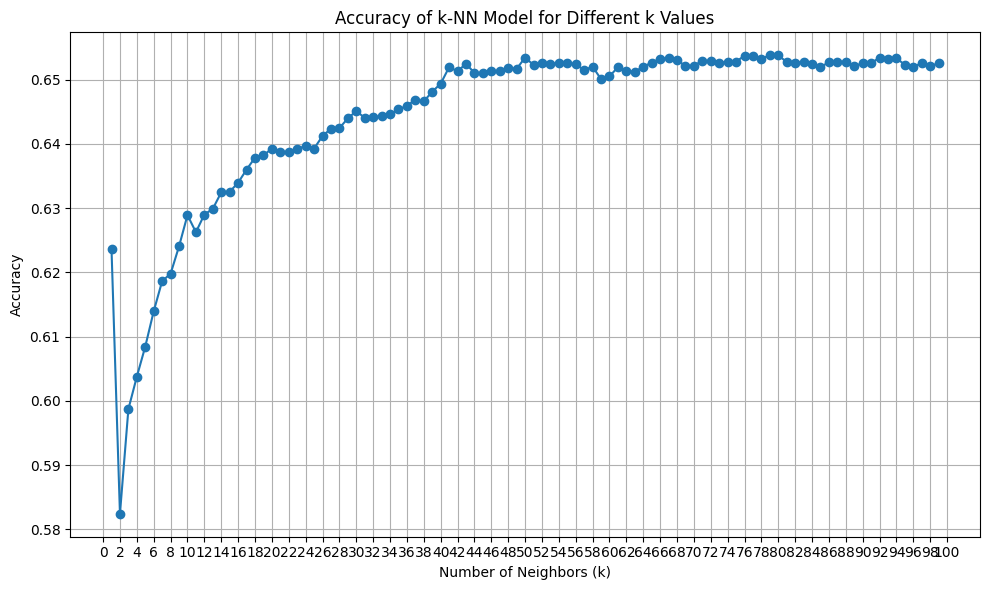

In [27]:
k_values=list(range(1,100))
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o')
plt.title('Accuracy of k-NN Model for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(0, 101, 2))
plt.tight_layout()
plt.show()